## importiere packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re                                    #string filter

from ast import literal_eval                 #string to dict
from tqdm import tqdm                        #progress indicator

from sklearn import datasets, linear_model   #linear regression
import matplotlib.pyplot as plt              #simple plots

import topojson                              #here: simplify polygons while keeping borders

import altair as alt                         #interactive plots
alt.renderers.enable('notebook')

import folium                                #helps to create leaflet maps with python
import branca                                #styling folium maps

In [2]:
df= pd.read_csv(r"csv\Rohdaten_Berlin_1992-2019_zda.csv")
df.head()

,filename,knoten,bez,datum,kurzken,zeit,art,art_len,rich,dict_zaehl
0,000EU7Y0,K 534,Spandauer Damm / BAB Stadtring (A 100) (Cha...,25.10.2004,K 534/04,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '15\t6\t0\t0\t-1', 8: '12\t3\t0\t..."
1,000SR9G0,K 1035,Hohenzollerndamm / BAB Stadtring (A 100) (W...,17.06.2009,K 1035/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->4', '2->1', '2-...","{'1->1': {7: '3\t0\t0\t0\t-1', 8: '0\t0\t0\t0\..."
2,000SZ9G1,K 1043,Berliner Straße / Konstanzer Straße - BAB A104...,18.06.2009,K 1043/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->3', '1->4', '2->1', '2->3', '2-...","{'1->3': {7: '662\t18\t8\t7\t-1', 8: '893\t22\..."
3,000YQ9FZ,K 1250,Hauptstr. / Wexstr.- BAB-A100 Stadtring (Innsb...,16.06.2009,K 1250/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '19\t2\t0\t0\t0', 8: '38\t1\t2\t0..."
4,0012W98P,K 1400,Saarstr. - Friedenauer Br. / BAB Abzw. Zehlend...,10.11.2008,K 1400/08,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '9\t0\t0\t0\t0', 8: '25\t1\t0\t0\..."


## erstelle je eine Spalte für Autos und Räder

In [3]:
for index, row in tqdm(df.iterrows()):
    
    #print (row['filename'])
    zaehl_dict= row['dict_zaehl']
    #print (zaehl_dict)
    zaehl_dict = literal_eval(zaehl_dict)
    
    art_list=row['art'].split(',') 

    ##########################CARS
    art_list_ix_cars= [i for i, j in enumerate(art_list) if j == 'Pkw+Lfw']
    if art_list_ix_cars:
        art_list_ix_cars = art_list_ix_cars[0]

    
    diic={}
    for keys,vals in zaehl_dict.items():
        # 0 fuer art=pkw
       # print (keys)
        #print (vals)
        if "Pkw+Lfw" in art_list:
            hour_counts_dict={}
            #f_words = [counts.split('\t')[0] for hours,counts in vals.items()]
            f_words = [counts.split('\t')[art_list_ix_cars] for hours,counts in vals.items()]
            for ix,hour_count in enumerate(f_words):
                hour_counts_dict[ix+int(row['zeit'][:2])]=hour_count
            
            if len(hour_counts_dict)>0:
                diic[keys]=hour_counts_dict
    #print (diic)
    
    #create col if not exists
    if 'car_counts' not in df.columns:
        df['car_counts'] = ''
    df.iloc[index, df.columns.get_loc('car_counts')] = str(diic)
    
    
#  ##########################BIKES
    art_list_ix_bikes= [i for i, j in enumerate(art_list) if j == 'Radf']
    if art_list_ix_bikes:
        art_list_ix_bikes = art_list_ix_bikes[0]
    else:
        pass
    
    diic={}
    for keys,vals in zaehl_dict.items():
        # 0 fuer art=pkw

        if ("Radf" in art_list):# and ("Radf" in art_list_ix_bikes):
            hour_counts_dict={}
            #f_words = [counts.split('\t')[0] for hours,counts in vals.items()]
            
            try:
                f_words = [counts.split('\t')[art_list_ix_bikes] for hours,counts in vals.items()]
            except:
                pass
            
            for ix,hour_count in enumerate(f_words):
                hour_counts_dict[ix+int(row['zeit'][:2])]=hour_count
            
            if len(hour_counts_dict)>0:
                diic[keys]=hour_counts_dict
    #print (diic)
    
    #create col if not exists
    if 'bike_counts' not in df.columns:
        df['bike_counts'] = ''
    df.iloc[index, df.columns.get_loc('bike_counts')] = str(diic)
    

17000it [01:51, 151.98it/s]


In [4]:
print ("df hat {} zeilen.".format(len(df)))

df hat 17000 zeilen.


In [5]:
df_zeitreihe= df[(df.car_counts !='{}') & (df.bike_counts !='{}') ].copy()

print ("df hat {} zeilen mit Zählungen für Rad und Auto.".format(len(df_zeitreihe)))

df hat 7617 zeilen mit Zählungen für Rad und Auto.


## ermittle den stündl. Durchschnitt je Zählung je Verkehrsmittel

In [6]:
df_zeitreihe['hour_counts_car']=0

for index,row in tqdm(df_zeitreihe.iterrows()):
    #digitalisiere string
    zaehl_dict = literal_eval(row.car_counts)
    
    #alle zaehlungen pro richtung
    values=zaehl_dict.values()
    summe=0
    hours=0
    
    #iterriere ueber jede richtung bzw stunden
    for l in list(values):
        try:
            l_int = list(map(int, l.values()))
            summe=summe+sum(l_int)
            hours=len(l)
        except:
            #print ("This is an error message!")
            l_int = 0

    #print (summe)
    #print (summe/hours)
    if hours>0:
        df_zeitreihe.at[index, 'hour_counts_car'] = summe/hours


7617it [00:06, 1187.55it/s]


In [7]:
df_zeitreihe['hour_counts_bike']=0

for index,row in tqdm(df_zeitreihe.iterrows()):
    #digitalisiere string
    zaehl_dict = literal_eval(row.bike_counts)
    
    #alle zaehlungen pro richtung
    values=zaehl_dict.values()
    summe=0
    hours=0
    
    #iterriere ueber jede richtung bzw stunden
    for l in list(values):
        try:
            l_int = list(map(int, l.values()))
            summe=summe+sum(l_int)
            hours=len(l)
        except:
            #print ("This is an error message!")
            l_int = 0

    #print (summe)
    #print (summe/hours)
    if hours>0:
        df_zeitreihe.at[index, 'hour_counts_bike'] = summe/hours

7617it [00:05, 1288.15it/s]


In [8]:
df_zeitreihe.sort_values('hour_counts_bike').tail()

,filename,knoten,bez,datum,kurzken,zeit,art,art_len,rich,dict_zaehl,car_counts,bike_counts,hour_counts_car,hour_counts_bike
3695,K0567102_20190401,K 0567102,Schönhauser Allee / Schivelbeiner Straße - Wic...,01.04.2019,K 0567102/18,"0700,1900","Pkw+Lfw,Lkw(>3.5t),Bus,Krad,Radf",5,"dict_keys(['1->2', '1->3', '1->4', '2->1', '2-...","{'1->2': {7: '91\t3\t0\t1\t26', 8: '90\t4\t0\t...","{'1->2': {7: '91', 8: '90', 9: '78', 10: '101'...","{'1->2': {7: '26', 8: '38', 9: '40', 10: '24',...",2149,1146
1190,K0000915_20140929,K 915,Skalitzer Str. - Oberbaumstr. / Köpenicker Str...,29.09.2014,K 915/14,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->2', '1->3', '1->4', '2->1', '2-...","{'1->2': {7: '26\t3\t0\t0\t0', 8: '10\t0\t0\t0...","{'1->2': {7: '26', 8: '10', 9: '27', 10: '25',...","{'1->2': {7: '0', 8: '0', 9: '19', 10: '6', 11...",2527,1160
3536,K0556765_20180828,K 556765,Schönhauser Allee / Eberswalder Straße - Danzi...,28.08.2018,K 556765/18,"0700,1900","Pkw+Lfw,Lkw(>3.5t),Bus,Krad,Radf",5,"dict_keys(['bemerk=Strom1>4und4>3verboten\\,bi...","{'bemerk=Strom1>4und4>3verboten\\,bittetrotzde...","{'bemerk=Strom1>4und4>3verboten\\,bittetrotzde...","{'bemerk=Strom1>4und4>3verboten\\,bittetrotzde...",2105,1324
3564,K0557403_20171019,K 557403,Karl-Marx-Allee - Alexanderplatz / Grunerstraß...,19.10.2017,K 557403/17,"0700,1900","Pkw+Lfw,Lkw(>3.5t),Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '3\t0\t0\t0\t0', 8: '9\t0\t2\t0\t...","{'1->1': {7: '3', 8: '9', 9: '8', 10: '8', 11:...","{'1->1': {7: '0', 8: '0', 9: '0', 10: '0', 11:...",2962,1410
9999,Q0901144_20170927,Q 0901144,Gertraudenbrücke -Leipziger Straße (nordöstl. ...,27.09.2017,Q 0901144/17,"0000,2400","Pkw+Lfw,Lkw(l),Lkw(s),Bus,Krad,Radf",6,dict_keys(['bemerk=Lkw(l)-->Lkw>3.5tmit2oder3A...,{'bemerk=Lkw(l)-->Lkw>3.5tmit2oder3AchsenohneA...,{'bemerk=Lkw(l)-->Lkw>3.5tmit2oder3AchsenohneA...,{'bemerk=Lkw(l)-->Lkw>3.5tmit2oder3AchsenohneA...,2762,1626


## filtere unplausible/fehlende Zählungen heraus (z.B. "-1")

In [9]:
df_zeitreihe_clean=df_zeitreihe[(df_zeitreihe['hour_counts_bike']>0) & (df_zeitreihe['hour_counts_bike']>0)].copy()

print ("{} 'plausible' Zählungen für Rad und Auto.".format(len(df_zeitreihe_clean)))

6974 'plausible' Zählungen für Rad und Auto.


In [10]:
df_zeitreihe_clean['datum'] =  pd.to_datetime(df_zeitreihe_clean['datum'])
df_zeitreihe_clean['year']=df_zeitreihe_clean['datum'].apply(lambda x: x.year)

df_zeitreihe_clean['Radanteil']=df_zeitreihe_clean.hour_counts_bike/(df_zeitreihe_clean.hour_counts_car + df_zeitreihe_clean.hour_counts_bike)

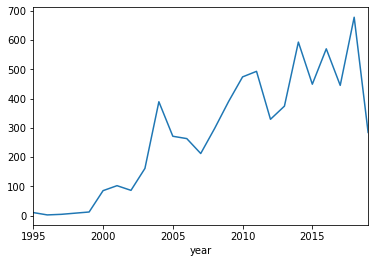

In [11]:
df_zeitreihe_clean.groupby('year')['year'].size().plot()

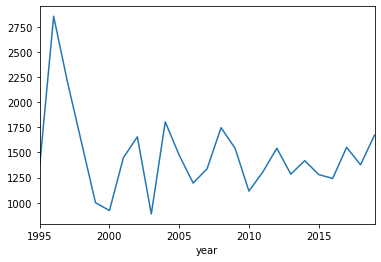

In [12]:
df_zeitreihe_clean.groupby('year')['hour_counts_car'].mean().plot()

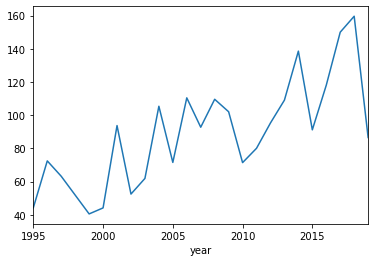

In [13]:
df_zeitreihe_clean.groupby('year')['hour_counts_bike'].mean().plot()

In [14]:
print (" {} Zählungen mit verwertbaren Daten".format(len(df_zeitreihe_clean.knoten.unique())))

 3736 Zählungen mit verwertbaren Daten


In [15]:
df_zeitreihe_clean.head()

,filename,knoten,bez,datum,kurzken,zeit,art,art_len,rich,dict_zaehl,car_counts,bike_counts,hour_counts_car,hour_counts_bike,year,Radanteil
0,000EU7Y0,K 534,Spandauer Damm / BAB Stadtring (A 100) (Cha...,2004-10-25,K 534/04,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '15\t6\t0\t0\t-1', 8: '12\t3\t0\t...","{'1->1': {7: '15', 8: '12', 9: '14', 10: '16',...","{'1->1': {7: '-1', 8: '-1', 9: '-1', 10: '-1',...",3656,33,2004,0.008946
1,000SR9G0,K 1035,Hohenzollerndamm / BAB Stadtring (A 100) (W...,2009-06-17,K 1035/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->4', '2->1', '2-...","{'1->1': {7: '3\t0\t0\t0\t-1', 8: '0\t0\t0\t0\...","{'1->1': {7: '3', 8: '0', 9: '0', 10: '0', 11:...","{'1->1': {7: '-1', 8: '-1', 9: '-1', 10: '-1',...",3609,150,2009,0.039904
2,000SZ9G1,K 1043,Berliner Straße / Konstanzer Straße - BAB A104...,2009-06-18,K 1043/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->3', '1->4', '2->1', '2->3', '2-...","{'1->3': {7: '662\t18\t8\t7\t-1', 8: '893\t22\...","{'1->3': {7: '662', 8: '893', 9: '902', 10: '9...","{'1->3': {7: '-1', 8: '-1', 9: '-1', 10: '-1',...",2621,17,2009,0.006444
3,000YQ9FZ,K 1250,Hauptstr. / Wexstr.- BAB-A100 Stadtring (Innsb...,2009-06-16,K 1250/09,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '19\t2\t0\t0\t0', 8: '38\t1\t2\t0...","{'1->1': {7: '19', 8: '38', 9: '33', 10: '25',...","{'1->1': {7: '0', 8: '0', 9: '0', 10: '0', 11:...",3433,195,2009,0.053749
4,0012W98P,K 1400,Saarstr. - Friedenauer Br. / BAB Abzw. Zehlend...,2008-10-11,K 1400/08,"0700,1900","Pkw+Lfw,Lkw,Bus,Krad,Radf",5,"dict_keys(['1->1', '1->2', '1->3', '1->4', '2-...","{'1->1': {7: '9\t0\t0\t0\t0', 8: '25\t1\t0\t0\...","{'1->1': {7: '9', 8: '25', 9: '19', 10: '13', ...","{'1->1': {7: '0', 8: '0', 9: '0', 10: '0', 11:...",2052,72,2008,0.033898


## filtere auf Zählorte wo mindestens 4 Zählungen standfanden

In [16]:
df_zeitreihe_clean = df_zeitreihe_clean[df_zeitreihe_clean.groupby("knoten")['knoten'].transform('size') > 3].copy()

In [17]:
print (" {} Zählungen mit mind. 4 Zählungen je Zählort".format(len(df_zeitreihe_clean)))

print (" an insg. {} Zählorten".format(len(df_zeitreihe_clean.knoten.unique())))

 2620 Zählungen mit mind. 4 Zählungen je Zählort
 an insg. 546 Zählorten


In [18]:
#erstelle plz spalte
df_zeitreihe_clean['plz']=df_zeitreihe_clean.bez.apply(lambda x: re.search(r'\d{5}', x).group(0) if re.search(r'\d{5}', x) is not None else '-1' ) #.str[:]
#df_zeitreihe_clean['plz']=df_zeitreihe_clean.bez.apply(lambda x: x[-7:-1])#.str[:]
#df_zeitreihe_clean.plz=df_zeitreihe_clean.plz.astype(str).str.replace(",", '').replace(" ", '')
#df_zeitreihe_clean.plz=df_zeitreihe_clean.plz.astype(str).str.replace(" ", '')
#df_zeitreihe_clean.plz=df_zeitreihe_clean.plz.astype(str).str.replace(")", '')

In [19]:
df_zeitreihe_clean.plz=df_zeitreihe_clean.plz.astype(str)
df_zeitreihe_clean=df_zeitreihe_clean[df_zeitreihe_clean.plz!='-1'].copy()#.sort_values('plz')

In [20]:
print (" in insg. {} PLZ-Gebieten".format(len(df_zeitreihe_clean.plz.unique())))

 in insg. 168 PLZ-Gebieten


## Berechne lineare Regression

In [21]:
def calcReg(df, year,Radanteil):

    x=df[year].values
    y=df[Radanteil].values

    length=len(df)
    x = x.reshape(length, 1)
    y = y.reshape(length, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    m = regr.coef_[0][0]

    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black', s=2)
    plt.plot(x, regr.predict(x), color='blue', linewidth=0.2)
    
    return m


In [22]:
df_zeitreihe_clean_kno=df_zeitreihe_clean.drop_duplicates(['knoten'])[['knoten','bez','plz']].reset_index()
df_zeitreihe_clean_kno.head()

,index,knoten,bez,plz
0,0,K 534,Spandauer Damm / BAB Stadtring (A 100) (Cha...,14059
1,1,K 1035,Hohenzollerndamm / BAB Stadtring (A 100) (W...,10718
2,2,K 1043,Berliner Straße / Konstanzer Straße - BAB A104...,10713
3,3,K 1250,Hauptstr. / Wexstr.- BAB-A100 Stadtring (Innsb...,10827
4,4,K 1400,Saarstr. - Friedenauer Br. / BAB Abzw. Zehlend...,12157


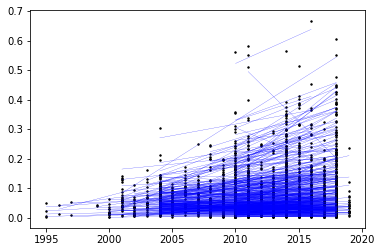

In [23]:
for i,k in enumerate(df_zeitreihe_clean_kno.knoten):#[:2]):#[:50]:
    df_zeitreihe_knoten=df_zeitreihe_clean[df_zeitreihe_clean['knoten']==k].copy()
    m=calcReg(df_zeitreihe_knoten, 'year','Radanteil')
    
    df_zeitreihe_clean_kno.at[i,'m']=m

In [24]:
df_zeitreihe_clean_kno.head()

,index,knoten,bez,plz,m
0,0,K 534,Spandauer Damm / BAB Stadtring (A 100) (Cha...,14059,0.001591
1,1,K 1035,Hohenzollerndamm / BAB Stadtring (A 100) (W...,10718,-0.001608
2,2,K 1043,Berliner Straße / Konstanzer Straße - BAB A104...,10713,0.000000
3,3,K 1250,Hauptstr. / Wexstr.- BAB-A100 Stadtring (Innsb...,10827,0.002154
4,4,K 1400,Saarstr. - Friedenauer Br. / BAB Abzw. Zehlend...,12157,0.001879


In [25]:
df_zeitreihe_clean_kno.m=df_zeitreihe_clean_kno.m*100
df_zeitreihe_clean_kno['plz_cnt'] = df_zeitreihe_clean_kno.groupby(['plz'])['plz'].transform('count')

In [26]:
#df_zeitreihe_clean_kno[df_zeitreihe_clean_kno.plz.str[:3]=='120']
df_zeitreihe_clean_kno[df_zeitreihe_clean_kno.plz=='12057']


,index,knoten,bez,plz,m,plz_cnt
135,1680,K 1442,"Grenzallee / Neuköllnische Allee,(Neukölln, 12...",12057,0.137608,6
139,1727,K 1498,Karl-Marx-Straße - Buschkrugallee / Grenzallee...,12057,0.078072,6
213,2738,K 2791,"Grenzallee / Zu-Abf. BAB (Neukölln, 12057)",12057,0.027034,6
214,2744,K 2792,"Späthstraße/ Zu- und Abfahrt BAB (Neukölln, ...",12057,0.089560,6
421,7633,Q 031202,"Dammweg (südl. Kiefholzstraße) (Neukölln, 12...",12057,0.012944,6
422,7645,Q 031204,Neuköllnische Allee (südöstl. Britzer Allee) ...,12057,-0.112427,6


In [27]:
#df_zeitreihe_clean_knoo_.groupby
grouped_plz_df=df_zeitreihe_clean_kno.groupby('plz')['m','plz_cnt'].mean().reset_index()

In [28]:
grouped_plz_df.sort_values('plz_cnt', ascending=False).head()

,plz,m,plz_cnt
20,10557,0.456519,19
1,10117,0.575899,16
4,10179,1.630766,11
46,10969,1.244861,10
92,12555,0.067094,9


In [29]:
grouped_plz_df.sort_values('m', ascending=False).head()

,plz,m,plz_cnt
123,13347,2.056876,1
4,10179,1.630766,11
126,13355,1.629420,2
47,10997,1.498211,3
53,12059,1.408010,1


---
## Visualisierung
* Chart
* Map

### lese vereinfachte PLZ ein und Bezirke aus OSM

In [30]:
bezirke_layer=gpd.read_file(r"shapes\BerlinerBezirke.geojson")
plz_layer=gpd.read_file(r"shapes\plz-gebiete_Generalized_lang_douglas_reduction_snakes_alle02_diss.shp")

#plz_table_path=r"C:\Users\Simon\Analysen\AgrarSubventionen\plz_table.csv"
#plz_table= pd.read_csv(plz_table_path)
#plz_table.head()
#plz_table[plz_table.zipcode==10365]

In [31]:
#schmeisse points raus
bezirke_layer=bezirke_layer[bezirke_layer.geometry.type!='Point'].copy()

In [32]:
#simplify bezirke
#krs.geometry= krs.buffer(0) #falls repair geometry notwendig
bezirke_layer_tj = topojson.Topology(bezirke_layer, prequantize=False, topology=True)
bezirke_layer_tj_sim = bezirke_layer_tj.toposimplify(0.002)
bezirke_layer_tj_sim = bezirke_layer_tj_sim.to_gdf()
bezirke_layer_tj_sim.crs={'init': 'epsg:4326'}

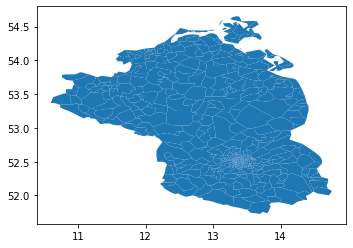

In [33]:
plz_layer[plz_layer.plz.str[:1]=='1'].plot()

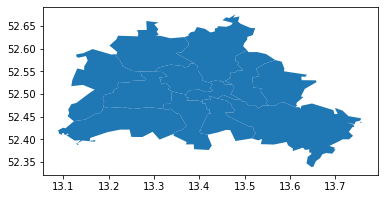

In [34]:
bezirke_layer_tj_sim.plot()

In [35]:
#plz_layer.plz=plz_layer.plz.astype(str).str.replace(" ", '')
#grouped_df.plz=grouped_df.plz.astype(str).str.replace(" ", '')

In [36]:
#grouped_plz_df.plz=grouped_plz_df.plz.asytpe(str)
#plz_layer.plz=plz_layer.plz.asytpe(str)

merged_plz = pd.merge(grouped_plz_df,plz_layer, on='plz', how='left')
merged_plz=merged_plz.dropna(subset=['geometry'])#.sort_values('geometry')

merged_plz.m= merged_plz.m.round(3)
merged_plz.head()

,plz,m,plz_cnt,geometry
0,10115,0.986,4,"(POLYGON ((13.3736395 52.5278007, 13.3658603 5..."
1,10117,0.576,16,(POLYGON ((13.40229208690467 52.51167373731749...
2,10119,0.562,2,"POLYGON ((13.3990212 52.5270137, 13.4011841 52..."
3,10178,1.211,7,"(POLYGON ((13.4254333 52.5234391, 13.4240706 5..."
4,10179,1.631,11,"(POLYGON ((13.4049444 52.5134685, 13.4259266 5..."


In [37]:
merged_plz_gdf = gpd.GeoDataFrame(
    merged_plz, geometry='geometry', crs={'init' :'epsg:4326'})

### Folium map preview

In [38]:
import branca
import folium

df=merged_plz_gdf
field='m'

colorscale = branca.colormap.LinearColormap(['red','orange','lightgray','lightgreen','green','#1164B4'], 
                                            index=[-1,df[field].min(),0,0.4,1,df[field].max()], 
                                            vmin=-1, 
                                            vmax=(df[field]).max(), 
                                            caption='')






def style_function(feature):
    col=feature['properties'][field]
    return {
        'fillOpacity': 0.5,
        'color':'white',
        'weight': 0.7,
        'fillColor': 'grey' if col is None else colorscale(col)
    }

m = folium.Map(location=[52.5, 13.4],
               #tiles="Stamen Toner",
               tiles="cartodbpositron",
               #tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png',
               #attr= "Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL." ,
               zoom_start=10)

##PLZ
folium.GeoJson(
    df,
    name='Veränderung des Radvekehrsanteils',
    tooltip=folium.GeoJsonTooltip(fields=['plz',field,'plz_cnt'],
                                  aliases=['PLZ','Veränderung des Radvekehrsanteils','Anzahl Zählungen in PLZ']),
    style_function=style_function
).add_to(m)


##Bezirke
folium.GeoJson(
    bezirke_layer_tj_sim,
    name='Bezirke',
    #attr="Berliner Bez",
    style_function=lambda x :{'color':'grey',
                             'fillColor':'None',
                             'weight':'1'}
).add_to(m)

colorscale.caption = 'Veränderung des Radvekehrsanteils [Prozenpunkte pro Jahr]'
m.add_child(colorscale)

folium.LayerControl(position='bottomleft').add_to(m)

m
#m.save('map.html')

### use the same, newest name (bez) for each place (knoten)

In [39]:
df_zeitreihe_clean_newestName=df_zeitreihe_clean.copy()

df_zeitreihe_clean_newestName['test'] = df_zeitreihe_clean_newestName.groupby(['knoten'])['datum'].transform(max)
df_newBez=df_zeitreihe_clean_newestName[df_zeitreihe_clean_newestName.datum==df_zeitreihe_clean_newestName.test][['knoten','bez']]

df_zeitreihe_clean_newBez=pd.merge(df_zeitreihe_clean_newestName,df_newBez, on='knoten', how='left')

### ALTAIR CHART JOSN PRODUCTION

In [40]:
df_zeitreihe_clean_newBez.columns

Index(['filename', 'knoten', 'bez_x', 'datum', 'kurzken', 'zeit', 'art',
       'art_len', 'rich', 'dict_zaehl', 'car_counts', 'bike_counts',
       'hour_counts_car', 'hour_counts_bike', 'year', 'Radanteil', 'plz',
       'test', 'bez_y'],
      dtype='object')

In [41]:
#df_=df_zeitreihe_clean[df_zeitreihe_clean.plz=='10969']

# iterrate over/create chart for all plz
for p in df_zeitreihe_clean_newBez.plz.unique():
    
    df_=df_zeitreihe_clean_newBez[df_zeitreihe_clean_newBez.plz==p]
    
    # filter all unneccesary, makes resul slimmer
    df_=df_[['knoten', 'bez_x', 'datum','zeit', 'art','hour_counts_car', 'hour_counts_bike', 'year', 'Radanteil', 'plz', 'bez_y']]


    selector = alt.selection_multi(fields=['bez_y'])
    color = alt.condition(selector,
                          alt.Color('bez_y:N', legend=None),
                          alt.value('lightgray'))

########## Scatter Plot
    points = alt.Chart(df_).mark_point().encode(
       # x='year:Q',
        x= alt.X('year:Q',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(format='0', title='Jahr')
        ),
        #y='Radanteil:Q',
        y=alt.Y('Radanteil:Q', axis=alt.Axis(format='%', title='Radanteil')),
        #color='knoten',
        color=color,#alt.Color('bez_y', legend=alt.Legend(title="Orte", labelLimit=300)),
        #tooltip=['datum','knoten','bez','Radanteil','hour_counts_bike']
        tooltip=[
            alt.Tooltip('datum', title='Datum'),
            alt.Tooltip('knoten', title='OrtsID'),
            alt.Tooltip('bez_x', title='Ort'),
            alt.Tooltip('hour_counts_bike', title='stündl. Anzahl von Radf'),
            alt.Tooltip('Radanteil', format='.1%',title='Radanteil')
        ],
    ).properties(
    title=df_.plz.values[-1]
    )#.add_selection(selector)

########## Lines Plot
    line=alt.Chart(df_).mark_line(size=1).encode(
        x='year:Q',
        y='Radanteil:Q',
        color=color,#'bez_y'
    ).transform_filter(
        selector
    )


########## regression / Ployfit

    x_='year'
    y_='Radanteil'

    degree=1

    all_polyData=pd.DataFrame()
    #df=df_zeitreihe_clean[df_zeitreihe_clean.plz=='10965']

    for k in df_.bez_y.unique():
        #print (k)
        df=df_[df_.bez_y==k]
        #print (df)
        poly_data=pd.DataFrame()

        # Build a dataframe with the fitted data
        poly_data = pd.DataFrame({'xfit': np.linspace(df[x_].min(), df[x_].max(), 10)})
        poly_data['yfit'] = np.poly1d(np.polyfit(df[x_], df[y_], degree))(poly_data['xfit'])
        poly_data['bez_y']=k#df.knoten.values[-1]
        all_polyData=all_polyData.append(poly_data)

    #poly_data=poly_data.rename(columns={'1':'yfit'})

########## Lines Plot  (polyfit result) 
    polynomial_fit = alt.Chart(all_polyData).mark_line(strokeDash=[10,10]).encode(
        x='xfit:Q',
        y='yfit:Q',
        color=color,#'bez_y',
        tooltip=['bez_y']

    ).transform_filter(
        selector
    )

########## legend Plot  (so make it selectable) 
    legend = alt.Chart(df_).mark_point().encode(
        y=alt.Y('bez_y:N', axis=alt.Axis(orient='right', title='Zählorte')),
        tooltip='bez_y',
        color=color
    ).add_selection(
        selector
    )


    #addon
    #https://altair-viz.github.io/gallery/multiline_tooltip.html

    allChrt=(points + line + polynomial_fit ) | legend


    allChrt.save('jsons_trendcharts\plz_trendChart_'+str(p)+'.json')

#allChrt
#polynomial_fit

C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poorly conditioned
C:\Users\Simon\Anaconda3\envs\geo_p\lib\site-packages\ipykernel_launcher.py:68: RankWarning: Polyfit may be poo

### show last created chart as an example

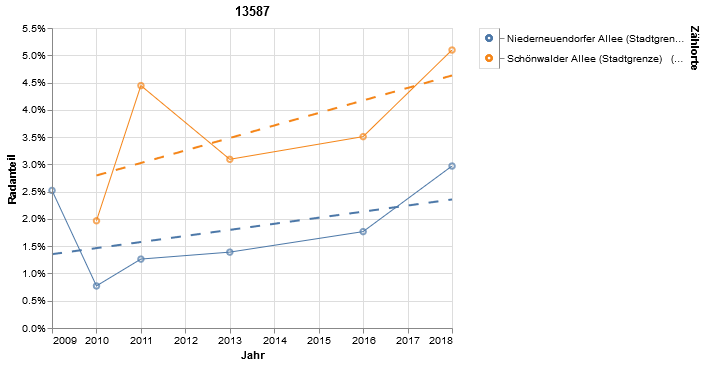

In [42]:
allChrt

### MAP mit Altair-Json on the fly

In [43]:
import branca
import folium
#import base64
#from folium import IFrame
#import json

df=merged_plz_gdf

df['m_str'] =df.m.apply(lambda x: str(round(x,2))+"%")
field='m'


#Styling
colorscale = branca.colormap.LinearColormap(['red','orange','lightgray','lightgreen','green','#1164B4'], 
                                            index=[-1,df[field].min(),0,0.4,1,df[field].max()], 
                                            vmin=-1, 
                                            vmax=(df[field]).max(), 
                                            caption='')

def style_function(feature):
    col=feature['properties'][field]
    return {
        'fillOpacity': 0.5,
        'color':'white',
        'weight': 0.7,
        'fillColor': 'grey' if col is None else colorscale(col)
    }

def highlight_function(feature):
    return {
        'color': 'grey',
        'weight': 2,
        'dashArray': '5, 5'
    }

##Basemaps
m = folium.Map(location=[52.5, 13.4],
               tiles="cartodbpositron",
               name="CartoDB light",
               #tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png',
               #attr= "Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL." ,
               zoom_start=11)

folium.TileLayer(tiles='https://tile.thunderforest.com/cycle/{z}/{x}/{y}.png?apikey=98ae7a41b031409bb9dbdad4b5720ae2',
                 name='OpenCycleMap',
                 attr='© OpenStreetMap contributors | OpenCycleMap'
                ).add_to(m)


#####LAYER     
###PLZ
folium.GeoJson(
    df,
    name='Veränderung Radvekehrsanteil je PLZ [{}]'.format(len(df)),
    tooltip=folium.GeoJsonTooltip(fields=['plz','m_str','plz_cnt'],
                                  aliases=['PLZ','durchschn. jährliche Veränderung des Radvekehrsanteils','Anzahl Zählungen in PLZ']),
    highlight_function=highlight_function,
    style_function=style_function
).add_to(m)

##Bezirke
folium.GeoJson(
    bezirke_layer_tj_sim,
    name='Bezirke',
    style_function=lambda x :{'color':'grey',
                             'fillColor':'None',
                             'weight':'1'}
).add_to(m)


## add colorscale and layer control
colorscale.caption = 'durchschn. Veränderung des Radvekehrsanteils [Prozenpunkte pro Jahr]'
m.add_child(colorscale)
  
folium.LayerControl(position='bottomleft',collapsed=True).add_to(m)


#export result as html
m.save(r"maps\map_wReg_cat_jsonChart_external_new.html")


### Some manual modifications of the html file are necessary

In [ ]:
# meight automize this with bs4?

# add libs
<script src="https://cdn.jsdelivr.net/npm/vega@5"></script>
<script src="https://cdn.jsdelivr.net/npm/vega-lite@3"></script>
<script src="https://cdn.jsdelivr.net/npm/vega-embed@4"></script>

# add css
            <style>
				html,
				body {
				   margin:0;
				   padding:0;
				   height:100%;
				   background: #efefef;
				}
				
                #map_e9a89690b863480e8e8094eeb8a49894 {
					min-height:100%;
                    position: relative;
					float: left;
                    width: 50%;
                    height: 100.0%;
                    left: 0.0%;
                    top: 0.0%;
                }
				
				#con {
				    min-height:100%;
				    position:relative;
					float: left;
					width: 50%;
					background: #efefef;
				}
				
				#vis {
					height: 650px;
					padding-bottom:0px;				
				}

				#text {
					position: absolute;
					text-align: right;
					height:280px;
					bottom: 20px;
					right: 20px;
					left: 20px;	
				}
				
				
				hr {
					position: relative;
					float: bottom;
					margin-bottom: 15px;
					margin-left: auto;
					margin-right: auto;
					border-style: inset;
					border-width: 1px;
				}
            </style>

# add to html body
<body>    
    
            <div class="folium-map" id="map_e9a89690b863480e8e8094eeb8a49894" ></div>
			
			<nav id="con">
				<ul>
				  <div id="vis"></div>
				</ul>
				
				

				
				<div id="text">
				  <hr>
				  <p>Diese Auswertung basiert auf den Rohdaten der Verkehrszählungen der Verkehrslenkung Berlin. 
				  In den vergangenen Jahrzehnten wurden ~20.000 Zählungen durchgeführt, wobei stündlich aufgelöst verschiedene Fahzeugytypen erfasst wurden.
				  In dieser Darstellung sind insgesamt nur ~2500 Zählungen eingeflossen, da nicht immer Rad und Kfz-Verkehr gleichzeigt gezählt wurde und z.T. unterschiedliche Datenformate vorliegen. Außerdem wurden hier nur Zählungen verwendet, für die mindestens 4 Zählungen pro Zählort vorliegen.
				  Daraus ergeben sich ~500 unterschiedliche Zählorten, die wiederum 160 von ~190 Plz-Gebieten innerhalb Berlins zugeordnet wurden.
				  Die Rohdaten und weitere Hinweise sind hier zu finden:</p>
				  <a href="https://github.com/vizsim/BerlinTrafficCounts">https://github.com/vizsim/BerlinTrafficCounts</a>
				  <br /> 
				  <br /> 
				  <p> Eine durchsuchbare Tabelle mit den Rohdaten gibts hier:</p>
				  <a href="https://vizsim.github.io/BerlinTrafficCounts/index.html">https://vizsim.github.io/BerlinTrafficCounts/index.html</a>
				</div>

			</nav>
        
</body>


# add js function to update chart
<script type="text/javascript">
  function showDivOnClick(url) {
  var spec = url;
  var opt = { 'padding':{"left": 20, "top": 20, "right": 20, "bottom": 20}}
  vegaEmbed('#vis', spec, opt).then(function(result) {
    // Access the Vega view instance (https://vega.github.io/vega/docs/api/view/) as result.view
  }).catch(console.error);
  }
</script>



# update source attributes
 var tile_layer_c54557b5c1a14a98ae21ace718061d3a = L.tileLayer(
                "https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png",
->                 {"attribution": "Verkehrslenkung Berlin / Rohdaten Verkehrszählungen, CC BY-SA 3.0 DE | \u0026copy; \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eOpenStreetMap\u003c/a\u003e contributors \u0026copy; \u003ca href=\"http://cartodb.com/attributions\"\u003eCartoDB\u003c/a\u003e, CartoDB \u003ca href =\"http://cartodb.com/attributions\"\u003eattributions\u003c/a\u003e", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
            ).addTo(map_e9a89690b863480e8e8094eeb8a49894);
    
    
# add/replace onclick function on polygons
function geo_json_64b309ff74554630a9b8cbb157d13d4b_onEachFeature(feature, layer) {
    layer.on({
        mouseout: function(e) {
            geo_json_64b309ff74554630a9b8cbb157d13d4b.resetStyle(e.target);
        },
        mouseover: function(e) {
            e.target.setStyle(geo_json_64b309ff74554630a9b8cbb157d13d4b_highlighter(e.target.feature));
        },
->        click: function(e) {
->                 showDivOnClick('https://vizsim.github.io/BerlinTrafficCounts/jsons_trendcharts/plz_trendChart_'+e.target.feature.properties['plz']+'.json')
        }
    });
    
    
# add rect, to get a white rect behind colorscale
color_map_0a88ac25eb3149f99126552da5a1ef17.svg = d3.select(".legend.leaflet-control").append("svg")
        .attr("id", 'legend')
        .attr("width", 450)
        .attr("height", 40);
	
-> color_map_0a88ac25eb3149f99126552da5a1ef17.svg.append("rect")
-> 	.attr("width", "100%")
-> 	.attr("height", "100%")
-> 	.attr("fill", "white")
-> 	.attr("opacity", "0.8");